In [1]:
import sys
sys.path.append('/home/mod/Workspace/bengali-2020')

In [2]:
from pathlib import Path
from bengali.dataset import BengaliDataset, get_transform
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
import torchvision

In [3]:
from bengali.grapheme.cutmix import cutmix, cutmix_criterion
from bengali.mixup import mixup

In [4]:
from bengali.grapheme.dataset import get_transform, GraphemeDataset

In [5]:
ROOT = os.path.dirname('/home/mod/Workspace/kaggle/Bengali/')

In [6]:
# DATA_ROOT = os.path.dirname('/home/mod/Workspace/kaggle/Bengali/grapheme-imgs-origin/')
DATA_ROOT = os.path.dirname('/home/mod/Workspace/kaggle/Bengali/grapheme-imgs-128x128/')

In [7]:
test_size = 128

In [8]:
def _get_transforms(*, normalise: bool = True, train: bool):
    test_sizes = [test_size]
    return [
        get_transform(
            train=train,
            test_size=test_size,
            normalize=normalise,
        ) for test_size in test_sizes]

def make_test_data_loader(df):
    return DataLoader(
        GraphemeDataset(
            df=df,
            transform=_get_transforms(train=False),
            root=DATA_ROOT,
        ),
        batch_size=16,
    )

def load_train_df(root: str = ROOT, train=True) -> pd.DataFrame:
    if train:
        df_path = os.path.join(root, 'train_debug.csv')
    else:
        df_path = os.path.join(root, 'test.csv')
    return pd.read_csv(df_path)

def load_train_valid_df(fold: int, task: str):

    df = load_train_df()
    if task == 'grapheme':
        classes = int((df.nunique())[1:2])
    else:
        # vowel and consonant
        classes = list(df.nunique())[2:-3]

    mask = df['fold'] == fold
    train = df[~mask]
    valid = df[mask]
    return train, valid, classes

In [9]:
train_df, valid_df, classes = load_train_valid_df(0, task='grapheme')
data_test_loader = make_test_data_loader(valid_df)
data_train_loader = DataLoader(
    GraphemeDataset(
        df=train_df,
        transform=_get_transforms(train=True),
        root=DATA_ROOT,
    ),
    batch_size=16,
    shuffle=True,
)

In [10]:
from tqdm import tqdm
import torch
import numpy as np

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
for idx, (input_image, label) in tqdm(
        enumerate(data_train_loader), total=len(data_train_loader),
):
    orgin_img = input_image
    input_image = input_image.to(device, dtype=torch.float)
    grapheme_label = label.to(device, dtype=torch.long)

    r = np.random.rand()
    alpha = np.random.uniform(low=0.8, high=1.)

    input_image, targets = cutmix(
        input_image, grapheme_label, alpha=alpha,
    )
    break

  0%|          | 0/1256 [00:02<?, ?it/s]


In [13]:
trans = torchvision.transforms.ToPILImage()

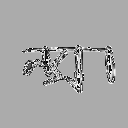

In [21]:
trans(orgin_img[4])

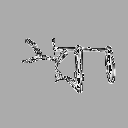

In [22]:
trans(input_image[4].cpu())

In [16]:
targets

[tensor([107,  38,  32, 112,  95,  72, 113, 100, 101, 120, 107,  81,  61,  89,
         122, 158], device='cuda:0'),
 tensor([122, 112, 101,  38, 158, 113,  95, 107, 100,  72,  61,  32,  81, 107,
          89, 120], device='cuda:0'),
 0.7113037109375]